# PATHWAY ABUNDANCE (fr now this time please)

## step 1: get all the packages in

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

## step 2: load all necessary data

In [75]:
# bowtie hit summaries for propionate
compiled_bt_hit_summaries_propionate = pd.read_csv("compiled_bt_hit_summaries_propionate.csv")

compiled_bt_hit_summaries_butyrate = pd.read_csv("compiled_bt_hit_summaries_butyrate.csv")

# total read counts for each SRA accession
readCountsDF = pd.read_csv("compiled_readCounts.csv")

# gene lengths 
propionate_gene_catalogue_seqlengths = pd.read_csv("propionate_gene_catalogue_seqlengths.csv")
butyrate_gene_catalogue_seqlengths = pd.read_csv("butyrate_gene_catalogue_seqlengths.csv")

## adding read count to df

### I think the `compiled_bt_hit_summaries_butyrate` given to me is wrong?? This is an attempt to fix that

In [76]:
compiled_bt_hit_summaries_butyrate = compiled_bt_hit_summaries_butyrate[compiled_bt_hit_summaries_butyrate.pathway != "propionate"]

### function to add read count + preprocess the data frames as required

In [77]:
def add_read_count(file, readCountsDF):
    return file.merge(readCountsDF, how="left", on="read_accession").drop(columns=['pathway']).set_index("read_accession").transpose()

### actually process the data frames

In [78]:
compiled_bt_hit_summaries_propionate = add_read_count(compiled_bt_hit_summaries_propionate, readCountsDF)

compiled_bt_hit_summaries_butyrate = add_read_count(compiled_bt_hit_summaries_butyrate, readCountsDF)

## gene length correction

### the function for gene length correction

In [79]:
def gene_length_correction(gene_catalogue_seqlengths, compiled_bt_hit_summaries, pathway):

    gene_length_df = gene_catalogue_seqlengths.set_index("gene")

    df = compiled_bt_hit_summaries

    new = compiled_bt_hit_summaries.copy()

    # first replace the values in new with the gene length of that gene
    for gene in compiled_bt_hit_summaries.index:
        
        if gene in gene_length_df.index:
        
            gene_length = gene_length_df.loc[gene].at["length"]

            new.loc[gene] = [gene_length] * len(new.columns)

    # then divide what would have been reads_gene by the actual values
    new = df.div(new)

    # then divide by the total amount of reads
    for read in df:

        total_reads_for_sample = df[read].iat[-1]

        new[read] = df[read].div(total_reads_for_sample)

    new.to_csv("compiled_bt_hit_summaries_" + pathway + "_length_corrected")

    return new

### running the code for gene length correction

In [80]:
compiled_bt_hit_summaries_propionate_length_corrected = gene_length_correction(propionate_gene_catalogue_seqlengths, compiled_bt_hit_summaries_propionate, "propionate")

compiled_bt_hit_summaries_butyrate_length_corrected = gene_length_correction(butyrate_gene_catalogue_seqlengths, compiled_bt_hit_summaries_butyrate, "butyrate")

## useful setup for calculating pathway abundances

In [81]:
pathway_gene_lists = []
pathways = []
pathway_dict = {}
pathway_length_dict = {}

# loop through the entire directory of gene lists
for file in os.listdir("geneLists"):

    # create a filename in the form of "geneLists/filename"
    file_n = "geneLists/" + str(file)

    # get the actual pathway from the filename
    pathway = str(file).replace("_gene_list.txt", "")

    # get the list of genes in each file
    geneList = [line.rstrip() for line in open(file_n)]

    pathways.append(pathway)

    # this my way of bypassing that strange assign function from R
    pathway_dict[pathway] = geneList

    pathway_length_dict[pathway + "_pathway_length"] = len(geneList)

    pathway_gene_lists.append(geneList)

# turn the gene pathways list of lists into a pandas dataframe, using `pathways` as the column names

gene_pathways_df = pd.DataFrame(pathway_gene_lists).transpose()

gene_pathways_df.columns = pathways

gene_pathways_df

,acetylCoA_buk,P3,P1_SP,aminobutyrate_buk,P1_WWC,lysine,glutarate,P2,acetylCoA_but,aminobutyrate_but
0,buk,fucO,methylmalonyl-CoA-mutase-EC5-4-99-2,buk,methylmalonyl-CoA-mutase-EC5-4-99-2,kal,hgdC,lcdA,but,but
1,hbd,pduP,methylmalonyl-CoA-epimerase-EC5-1-99-1,ptb,methylmalonyl-CoA-epimerase-EC5-1-99-1,kamA,hgdB,lcdB,hbd,abfD
2,ptb,pduC,methylmalonyl-CoA-decarboxylaseGamma-KOK23351,abfD,methylmalonyl-CoA-carboxyltransferase12S-KOK17489,kamD,hgdA,lcdC,thl,abfH
3,thl,pduD,methylmalonyl-CoA-decarboxylaseDelta-KOK23352,abfH,methylmalonyl-CoA-carboxyltransferase5S-KOK03416,kamE,gctA,acrC,bcd,abfT
4,bcd,pduE,methylmalonyl-CoA-decarboxylaseBeta-KOK20509,abfT,methylmalonyl-CoA-carboxyltransferase1-3S-KOK1...,kce,gctB,pct,cro,bcd
5,cro,pduL,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,bcd,None,kdd,gcdB,None,None,None
6,None,pduW,None,None,None,atoA,gcdA,None,None,None
7,None,None,None,None,None,atoD,but,None,None,None
8,None,None,None,None,None,bcd,buk,None,None,None
9,None,None,None,None,None,None,ptb,None,None,None


## calculating pathway abundances

### generate the dataframe to put everything in

In [82]:
# input: give a list of all dataframes that you wish to consider

def generate_final_df(gene_catalogues, columnNames):

    # get all the gene names from the gene catalogues
    index_list = []
    for catalogue in gene_catalogues:
        index_list += list(catalogue.gene)

    # return a final dataframe with all the gene names as the index, and the column names as specified
    # rename index of this dataframe to "gene_full_name"
    return pd.DataFrame(index = index_list, columns = columnNames)

### create the dataframe to put everything in, using the function `generate_final_df` 

In [83]:
colNames = ["gene_name_short", "overall_pathway"]

gene_catalogue_list = [propionate_gene_catalogue_seqlengths]

propionate_final_test = generate_final_df(gene_catalogue_list, colNames)

propionate_final_test

,gene_name_short,overall_pathway
Alistipes-indistinctus-YIT-12060-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN,NaN
Alistipes-onderdonkii-DSM-19147-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN,NaN
Alistipes-putredinis-DSM-17216-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN,NaN
Alistipes-senegalensis-JC50-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN,NaN
Alistipes-shahii-WAL-8301-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN,NaN
...,...,...
Blautia-wexlerae-DSM-19850-MAF-2_pduW,NaN,NaN
Enterocloster-asparagiformis-DSM-15981-MAF-2_pduW,NaN,NaN
Enterocloster-bolteae-ATCC-BAA-613-MAF-2_pduW,NaN,NaN
Roseburia-inulinivorans-strain-AF28-15_pduW,NaN,NaN


### create the "short" gene names and add them to the table

In [84]:
propionate_final_test["gene_name_short"] = [gene.split("_")[-1] for gene in list(propionate_final_test.index.values)]

propionate_final_test

,gene_name_short,overall_pathway
Alistipes-indistinctus-YIT-12060-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN
Alistipes-onderdonkii-DSM-19147-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN
Alistipes-putredinis-DSM-17216-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN
Alistipes-senegalensis-JC50-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN
Alistipes-shahii-WAL-8301-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN
...,...,...
Blautia-wexlerae-DSM-19850-MAF-2_pduW,pduW,NaN
Enterocloster-asparagiformis-DSM-15981-MAF-2_pduW,pduW,NaN
Enterocloster-bolteae-ATCC-BAA-613-MAF-2_pduW,pduW,NaN
Roseburia-inulinivorans-strain-AF28-15_pduW,pduW,NaN


### ok now we calculate the abundances???

In [85]:
summed_propionate = compiled_bt_hit_summaries_propionate_length_corrected.sum(axis=1)

summed_propionate.name = "pathway_abundance"

propionate_final_test = propionate_final_test.merge(summed_propionate, how = "left", left_index=True, right_index=True)

propionate_final_test

,gene_name_short,overall_pathway,pathway_abundance
Alistipes-indistinctus-YIT-12060-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN,0.000026
Alistipes-onderdonkii-DSM-19147-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN,0.000517
Alistipes-putredinis-DSM-17216-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN,0.000549
Alistipes-senegalensis-JC50-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN,0.000053
Alistipes-shahii-WAL-8301-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN,0.000227
...,...,...,...
Blautia-wexlerae-DSM-19850-MAF-2_pduW,pduW,NaN,0.000546
Enterocloster-asparagiformis-DSM-15981-MAF-2_pduW,pduW,NaN,0.000006
Enterocloster-bolteae-ATCC-BAA-613-MAF-2_pduW,pduW,NaN,0.000049
Roseburia-inulinivorans-strain-AF28-15_pduW,pduW,NaN,0.000094


### `get_overall_pathway` gets the correct overall pathways given a dataframe with gene_name_short propigated already

In [92]:
def get_overall_pathway(df, gene_pathways_df):

    overall_pathway_list = []

    genes_with_duplicates = ["methylmalonyl-CoA-mutase-EC5-4-99-2", "methylmalonyl-CoA-epimerase-EC5-1-99-1", "buk", "but"]

    result = ""

    for gene in list(df.gene_name_short):

        modified = False

        for pathway_name in gene_pathways_df:

            if gene in set(gene_pathways_df[pathway_name]):

                if gene not in genes_with_duplicates:

                    overall_pathway_list.append(pathway_name) 

                    modified = True

                    break

                else:

                    if gene == "buk":

                        overall_pathway_list.append("acetylCoA_buk/aminobutyrate_buk")

                        modified = True

                        break

                    if gene == "but":
                        
                        overall_pathway_list.append("acetylCoA_but/aminobutyrate_but")

                        modified = True

                        break


                    if gene == "methylmalonyl-CoA-mutase-EC5-4-99-2" or "methylmalonyl-CoA-epimerase-EC5-1-99-1":
                        
                        overall_pathway_list.append("P1_SP/P1_WCC")

                        modified = True

                        break


        if not modified: overall_pathway_list.append(None)

    df["overall_pathway"] = overall_pathway_list

    return df


### actually get the overall pathways using the function defined above

In [87]:
propionate_final_test = get_overall_pathway(propionate_final_test, gene_pathways_df=gene_pathways_df)

propionate_final_test

,gene_name_short,overall_pathway,pathway_abundance
Alistipes-indistinctus-YIT-12060-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP,0.000026
Alistipes-onderdonkii-DSM-19147-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP,0.000517
Alistipes-putredinis-DSM-17216-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP,0.000549
Alistipes-senegalensis-JC50-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP,0.000053
Alistipes-shahii-WAL-8301-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP,0.000227
...,...,...,...
Blautia-wexlerae-DSM-19850-MAF-2_pduW,pduW,P3,0.000546
Enterocloster-asparagiformis-DSM-15981-MAF-2_pduW,pduW,P3,0.000006
Enterocloster-bolteae-ATCC-BAA-613-MAF-2_pduW,pduW,P3,0.000049
Roseburia-inulinivorans-strain-AF28-15_pduW,pduW,P3,0.000094


## playing around with groupby to see what I get

In [93]:
# propionate_final_test["overall_pathway"] = []

# [gene.split("_")[1] for gene in list(propionate_final_test.index.values)]

gene_short_groupby = propionate_final_test.groupby("gene_name_short").sum()

gene_short_groupby

,overall_pathway,pathway_abundance
gene_name_short,,
Roseburia-inulivorans-pduCDE,0,1.690448e-03
acrC,P2P2P2P2,2.661919e-06
fucO,P3P3P3P3P3,1.042562e-03
lcdA,P2P2P2P2,1.800026e-05
lcdB,P2P2P2P2,1.532855e-05
lcdC,P2P2P2P2,9.423211e-06
methylmalonyl-CoA-carboxyltransferase1-3S-KOK17490,P1_WWCP1_WWCP1_WWCP1_WWCP1_WWCP1_WWCP1_WWCP1_W...,7.254236e-07
methylmalonyl-CoA-carboxyltransferase12S-KOK17489,P1_WWCP1_WWCP1_WWCP1_WWCP1_WWCP1_WWCP1_WWCP1_W...,7.306020e-06
methylmalonyl-CoA-carboxyltransferase5S-KOK03416,P1_WWCP1_WWCP1_WWCP1_WWCP1_WWCP1_WWCP1_WWCP1_W...,8.612709e-06


In [94]:
overall_pathway_groupby = propionate_final_test.groupby("overall_pathway").sum()

overall_pathway_groupby

,gene_name_short,pathway_abundance
overall_pathway,,
P1_SP,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604m...,0.027010
P1_SP/P1_WCC,methylmalonyl-CoA-epimerase-EC5-1-99-1methylma...,0.027671
P1_WWC,methylmalonyl-CoA-carboxyltransferase1-3S-KOK1...,0.000017
P2,acrCacrCacrCacrClcdAlcdAlcdAlcdAlcdBlcdBlcdBlc...,0.000059
P3,fucOfucOfucOfucOfucOpduCpduLpduLpduLpduLpduLpd...,0.003653


## random plots testing time

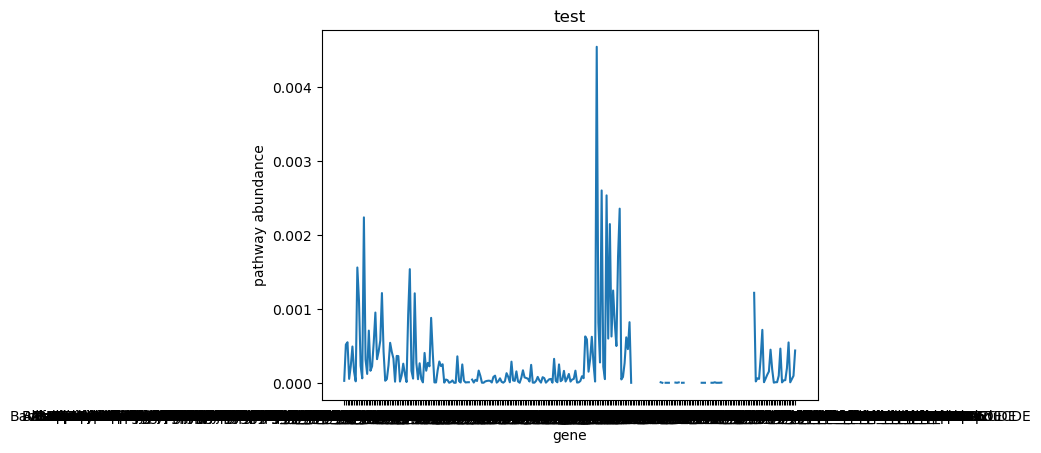

In [95]:
fig, ax = plt.subplots()

ax.plot(list(propionate_final_test.index.values), list(propionate_final_test.pathway_abundance))

ax.set(xlabel="gene", ylabel="pathway abundance", title="test")

plt.show()

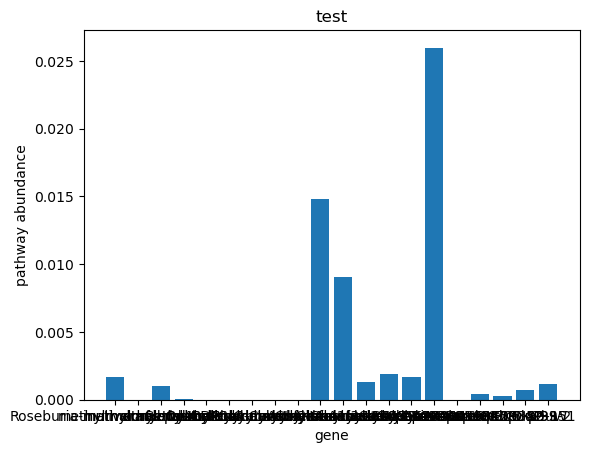

In [96]:
fig, ax = plt.subplots()

ax.bar(list(gene_short_groupby.index.values), list(gene_short_groupby.pathway_abundance))

ax.set(xlabel="gene", ylabel="pathway abundance", title="test")

plt.show()